# Extended Wigner's friend scenario

An adapted notebook from Will pertaining to the extended Wigner's friend scenario.

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- https://arxiv.org/abs/2109.02298
- https://arxiv.org/abs/2209.06236

## Imports

In [1]:
from typing import Optional
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm

import qiskit
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram

## Constants

In [2]:
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
    
class Observer(Enum):
    ALICE = 0
    BOB = 1

# Size of the bipartite quantum system.
SYS_SIZE = 2

# Size of the systems held by the "friends" (Charlie and Debbie).
CHARLIE_SIZE = 3
DEBBIE_SIZE = 3

# Two output bits for Alice and Bob.
MEAS_SIZE = 2

# Size of entire circuit
CIRCUIT_SIZE = SYS_SIZE + CHARLIE_SIZE + DEBBIE_SIZE

ALICE = Observer.ALICE.value
BOB = Observer.BOB.value

PEEK = Setting.PEEK
REVERSE_1 = Setting.REVERSE_1
REVERSE_2 = Setting.REVERSE_2

SETTINGS = [PEEK, REVERSE_1, REVERSE_2]
OBSERVERS = [ALICE, BOB]

In [3]:
# Ideal simulator backend.
backend = AerSimulator()
svsim = Aer.get_backend("statevector_simulator")

## State preparation

In [4]:
def prepare_bipartite_system() -> QuantumCircuit:
    """Generates the state: 1/sqrt(3) * (|00> + |01> + |10>)"""
    qc = QuantumCircuit(2)
    qc.ry(2 * np.arccos(np.sqrt(2/3)), 0)
    qc.ry(np.pi/4, 1)
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)
    qc.ry(-np.pi/4, 1) 
    return qc

Confirm that the state preparation circuit generates $|\psi\rangle = \frac{1}{\sqrt{3}}\left(|00\rangle + |01\rangle + 10\rangle\right)$:

In [5]:
circuit = prepare_bipartite_system()
print(svsim.run(circuit).result().get_counts())

{'00': 0.333333333333333, '01': 0.333333333333333, '10': 0.333333333333333}


## CNOT ladder circuit

In [6]:
def cnot_ladder(system_qubit: int, friend_qubit: int, friend_size: int) -> QuantumCircuit:
    """CNOT ladder circuit (GHZ without Hadamrd)."""
    circuit = QuantumCircuit(CIRCUIT_SIZE)
    for i in range(friend_size):
        circuit.cx(system_qubit, friend_qubit + i)
    return circuit

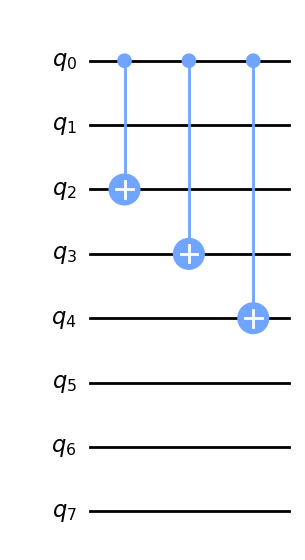

In [7]:
cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE).draw("mpl")

## Circuit for extended Wigner's friend scenario

In [8]:
def ewfs(alice: Setting, bob: Setting, angles: Optional[list[float]] = None):
    """Generate the circuit for extended Wigner's friend scenario."""
    if angles is None:
        angles = [np.pi/2, np.pi/2]

    # Observable circuits
    charlie_obs = cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE)
    debbie_obs = cnot_ladder(BOB, SYS_SIZE + CHARLIE_SIZE, DEBBIE_SIZE)
        
    # Initialize circuit that defines the extended scenario.
    qc = QuantumCircuit(CIRCUIT_SIZE, MEAS_SIZE) 
    
    # State prep
    qc = qc.compose(prepare_bipartite_system())    

    qc = qc.compose(charlie_obs)
    qc = qc.compose(debbie_obs)    

    # 0: Charlie system; 2: Charlie; [0]: Alice
    if alice is PEEK:
        # Ask Charlie for the outcome. We pick a random qubit from Charlie's register.
        random_offset = random.randint(0, CHARLIE_SIZE-1)
        qc.measure(SYS_SIZE + random_offset, ALICE)
    else:
        # Undo the measurement
        qc = qc.compose(charlie_obs)
        # Alice measures directly in a different basis
        qc.rz(np.pi/2, ALICE)
        qc.rx(np.pi/2, ALICE)
        if alice is REVERSE_1:
            qc.rz(angles[0], ALICE)
        elif alice is REVERSE_2:
            qc.rz(angles[1], ALICE)
        qc.measure(ALICE, ALICE)

    # 1: Debbie system; 3: Debbie; [1]: Bob
    if bob is PEEK:
        # Ask Debbie for the outcome. We pick a random qubit from Debbie's register.
        random_offset = random.randint(0, DEBBIE_SIZE-1)
        qc.measure(SYS_SIZE + CHARLIE_SIZE + random_offset, BOB)
    else:
        # Undo the measurement
        qc = qc.compose(debbie_obs)    
        # Bob measures directly in a different basis
        qc.rz(np.pi/2, BOB)
        qc.rx(np.pi/2, BOB)
        if bob is REVERSE_1:
            qc.rz(angles[0], BOB)
        elif bob is REVERSE_2:
            qc.rz(angles[1], BOB)
        qc.measure(BOB, BOB)
    
    return qc

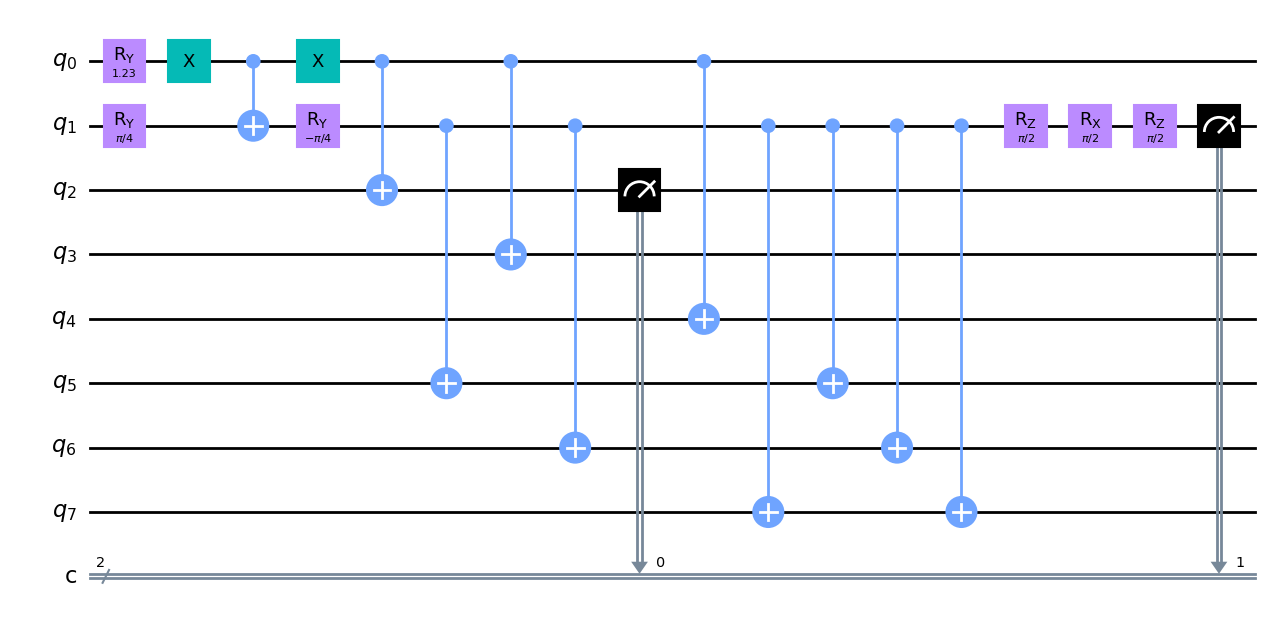

In [9]:
qc = ewfs(PEEK, REVERSE_1)
qc.draw("mpl")

In [10]:
ewfs_circuit = ewfs(PEEK, PEEK)

result = backend.run(ewfs_circuit).result()
counts = result.get_counts(0)
print(f"Counts: {counts}")

Counts: {'01': 368, '00': 315, '10': 341}


## Consider all experimental settings

In [11]:
def generate_all_experiments(angles=None):
    """Generate probabilitites for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))

    results = {}
    for alice, bob in all_experiment_combos:
        ewfs_circuit = ewfs(alice, bob, angles)
        result = backend.run(ewfs_circuit).result()
        counts = result.get_counts(0)

        # Convert counts to probabilities
        total_shots = sum(counts.values())
        probabilities = {key: value / total_shots for key, value in counts.items()}

        results[(alice, bob)] = probabilities
    return results

In [12]:
def marginalize(bitstring_probs, indices):
    marginalized_probs = {}
    for bitstring, prob in bitstring_probs.items():
        # Extract the bits at the specified indices
        marginalized_bitstring = "".join([bitstring[i] for i in indices])
        
        # Add the probability to the marginalized_probs dictionary
        if marginalized_bitstring in marginalized_probs:
            marginalized_probs[marginalized_bitstring] += prob
        else:
            marginalized_probs[marginalized_bitstring] = prob
            
    return marginalized_probs

In [13]:
def single_expect(observer, setting: Setting, results): #obs = 0 for Alice and 2 for Bob
    expect, denom = 0, 0
    for settings, probs in results.items():
        if settings[observer] is setting:
            expect += marginalize(probs, [observer])["1"]
            denom += 1
    return expect / denom

In [14]:
def double_expect(settings, results):
    probs = results[settings]
    try:
        val = probs["11"]
    except KeyError:
        val = 0
    return val

## Inequalities

In [15]:
results = generate_all_experiments()

In [16]:
A1 = single_expect(ALICE, PEEK, results)
B1 = single_expect(BOB, PEEK, results)

A2 = single_expect(ALICE, REVERSE_1, results)
B2 = single_expect(BOB, REVERSE_1, results)

A3 = single_expect(ALICE, REVERSE_2, results)
B3 = single_expect(BOB, REVERSE_2, results)

A1B1 = double_expect((PEEK, PEEK), results)
A1B2 = double_expect((PEEK, REVERSE_1), results)
A1B3 = double_expect((PEEK, REVERSE_2), results)

A2B1 = double_expect((REVERSE_1, PEEK), results)
A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

A3B1 = double_expect((REVERSE_2, PEEK), results)
A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
A3B3 = double_expect((REVERSE_2, REVERSE_2), results)

In [17]:
semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2
brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2

lf_1 = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
lf_2 = -A1 - A2 - A3 - B1 - A1B1 - A2B1 - A3B1 - 2*A1B2 + A2B2 + A3B2 - A2B3 + A3B3 - 5
lf_3 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 
lf_4 = -A2 - A3 - B2 - B3 - A1B2 + A1B3 - A2B1 - A2B2 - A2B3 + A3B1 - A3B2 - A3B3 - 4

print("******Inequalities******")
print(f"semi-brukner: {semi_brukner}")
print(f"brukner: {brukner}")
print(f"lf_1: {lf_1}")
print(f"lf_2: {lf_2}")
print(f"lf_3: {lf_3}")
print(f"lf_4: {lf_4}")
print("**************************")

******Inequalities******
semi-brukner: -2.1708984375
brukner: -2.4091796875
lf_1: -7.585611979166666
lf_2: -6.340494791666666
lf_3: -4.704752604166667
lf_4: -5.233723958333334
**************************


## Experiment

In [18]:
is_violated = False
for angle_1 in tqdm(np.linspace(0, 360, num=10)):
    for angle_2 in np.linspace(0, 360, num=10):
        results = generate_all_experiments([angle_1, angle_2])

        A1 = single_expect(ALICE, PEEK, results)
        B1 = single_expect(BOB, PEEK, results)

        A2 = single_expect(ALICE, REVERSE_1, results)
        B2 = single_expect(BOB, REVERSE_1, results)

        A3 = single_expect(ALICE, REVERSE_2, results)
        B3 = single_expect(BOB, REVERSE_2, results)

        A1B1 = double_expect((PEEK, PEEK), results)
        A1B2 = double_expect((PEEK, REVERSE_1), results)
        A1B3 = double_expect((PEEK, REVERSE_2), results)

        A2B1 = double_expect((REVERSE_1, PEEK), results)
        A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
        A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

        A3B1 = double_expect((REVERSE_2, PEEK), results)
        A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
        A3B3 = double_expect((REVERSE_2, REVERSE_2), results)

        semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2
        brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2

        lf_1 = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
        lf_2 = -A1 - A2 - A3 - B1 - A1B1 - A2B1 - A3B1 - 2*A1B2 + A2B2 + A3B2 - A2B3 + A3B3 - 5
        lf_3 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 
        lf_4 = -A2 - A3 - B2 - B3 - A1B2 + A1B3 - A2B1 - A2B2 - A2B3 + A3B1 - A3B2 - A3B3 - 4

        if semi_brukner > 0:
            is_violated = True
print(is_violated)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.15it/s]

False


## Testing arxiv:2109.02298

In [19]:
def U(theta: float = np.pi/4):
    """Defined between equations (2) and (3) in arXiv:2109.02298."""
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    matrix = np.cos(theta) * sigma_z + np.sin(theta) * sigma_x
    return UnitaryGate(matrix, label="U_θ")

### Circuit from Fig. 4

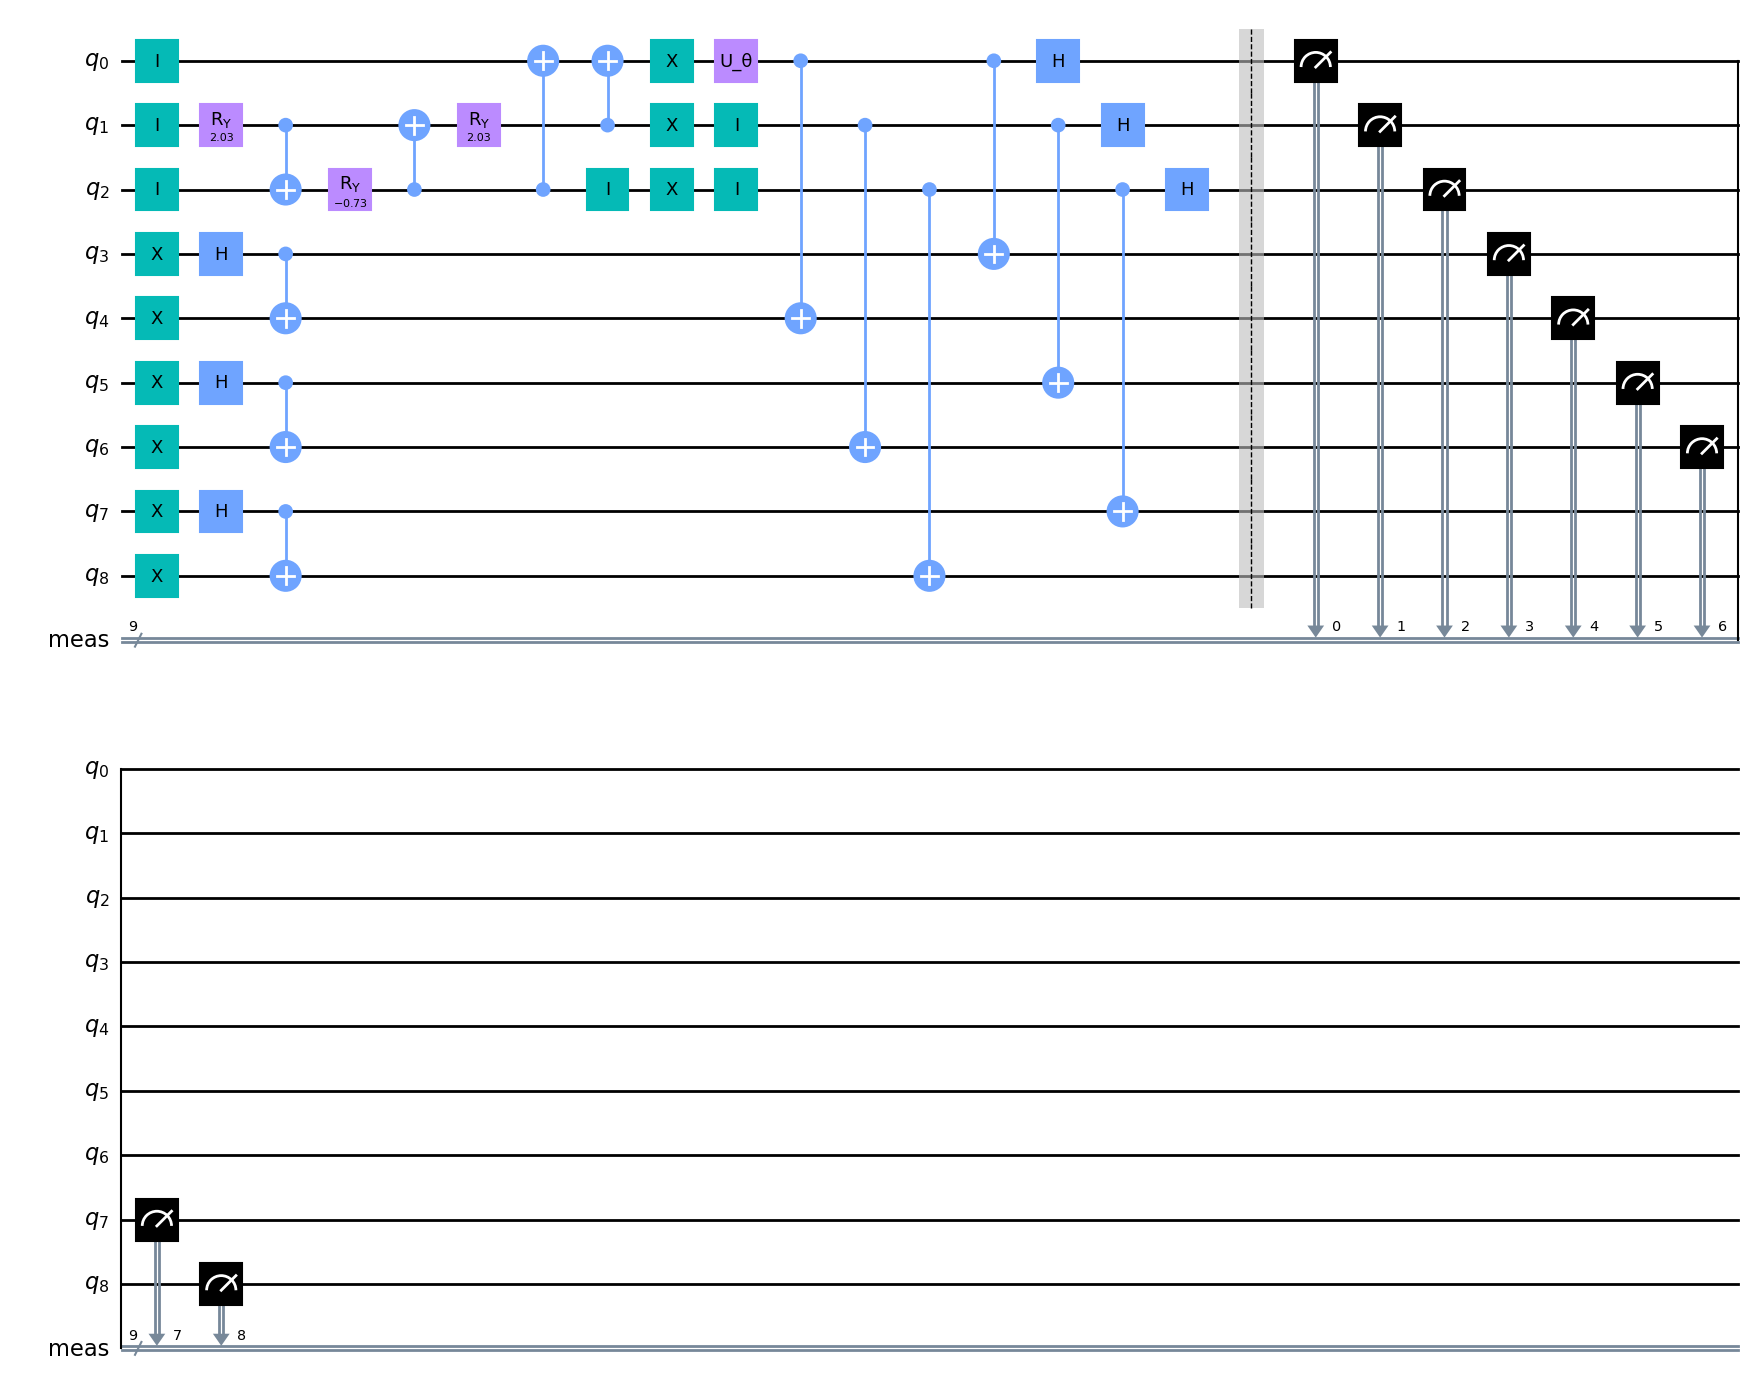

In [20]:
eta_1 = 2 * np.arcsin(np.sqrt((5 + np.sqrt(5)) / 10))
eta_2 = -2 * np.arcsin(np.sqrt((3 - np.sqrt(5)) / 6))
eta_3 = eta_1
qc = QuantumCircuit(9)

# Init qubits 3-8 to |1>
qc.i(0)
qc.i(1)
qc.i(2)
qc.x(3)
qc.x(4)
qc.x(5)
qc.x(6)
qc.x(7)
qc.x(8)

qc.ry(eta_1, 1)
qc.h(3)
qc.h(5)
qc.h(7)

qc.cx(1, 2)
qc.cx(3, 4)
qc.cx(5, 6)
qc.cx(7, 8)

qc.ry(eta_2, 2)

qc.cx(2, 1)

qc.ry(eta_3, 1)

qc.cx(2, 0)
qc.cx(1, 0)

qc.x(0)
qc.x(1)
qc.i(2)
qc.x(2)

qc.append(U(), [0])

qc.cx(0, 4)
qc.i(1)
qc.cx(1, 6)
qc.i(2)
qc.cx(2, 8)

qc.cx(0, 3)
qc.h(0)
qc.cx(1, 5)

qc.h(1)
qc.cx(2, 7)

qc.h(2)

qc.measure_all()

qc.draw("mpl")

In [21]:
result = backend.run(qc).result()
counts = result.get_counts(0)

for count in counts:
    if count[-1] == '1' and count[-2] == '0' and count[-3] == '0':
        print(count)
#print(f"Counts: {counts}")
#hist1 = plot_histogram(counts, sort="value_desc")
#display(hist1)

011010001
011001001
010101001
100101001
101010001
100110001
010110001
101001001


In [22]:
def w_state():
    eta_1 = 2 * np.arcsin(np.sqrt((5 + np.sqrt(5)) / 10))
    eta_2 = -2 * np.arcsin(np.sqrt((3 - np.sqrt(5)) / 6))
    eta_3 = eta_1
    qc = QuantumCircuit(3)
    
    qc.ry(eta_1, 1)
    qc.cx(1, 2)
    qc.ry(eta_2, 2)
    qc.cx(2, 1)
    qc.ry(eta_2, 1)
    qc.cx(2, 0)
    qc.cx(1, 0)
    qc.x(0)
    qc.x(1)
    qc.i(2)
    qc.x(2)
    
    return qc

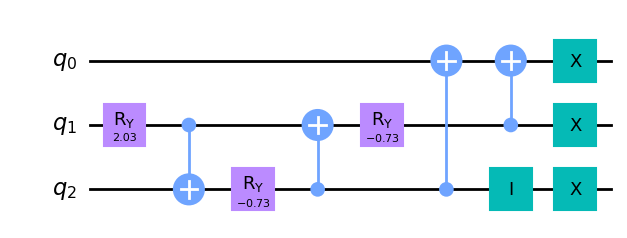

In [23]:
qc = w_state()

qc.draw("mpl")

In [24]:
circuit = w_state()
print(svsim.run(circuit).result().get_counts())

{'001': 0.210491910111102, '010': 0.456174756555565, '100': 0.01173031211112, '111': 0.321603021222213}


In [25]:
def u_rot(theta, idx):
    matrix = np.array([
        [np.cos(theta/2), np.sin(theta/2)],
        [np.sin(theta/2), -np.cos(theta/2)]
    ])
    return UnitaryGate(matrix, label=f"U_θ{idx}")

In [26]:
def w_state_unitary():
    theta_1 = np.arccos(1/np.sqrt(3))
    theta_2 = np.pi/4
    qc = QuantumCircuit(3)
    
    # Flip |0> -> |1>
    qc.x(0)
    qc.i(1)
    qc.i(2)
    
    qc.append(u_rot(theta_1, 1), [1])
    
    qc.h(1)
    qc.cx(0, 1)
    qc.h(1)
    
    qc.append(u_rot(theta_1, 1), [1])
    qc.i(2)
    qc.i(2)
    qc.i(2)
    qc.i(2)
    qc.append(u_rot(theta_2, 2), [2])    
    
    qc.cx(1, 0)
    qc.h(2)
    
    qc.cx(1, 2)
    qc.h(2)
    
    qc.append(u_rot(theta_2, 2), [2])
    
    qc.cx(2, 1)
    
    return qc

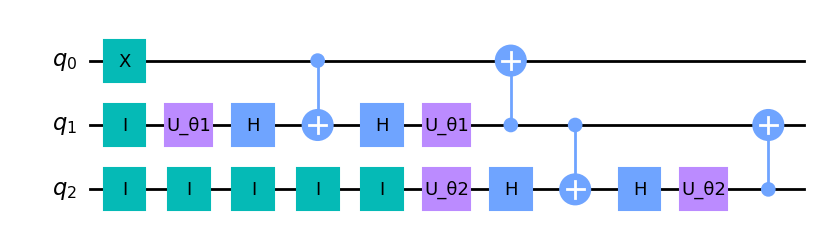

In [27]:
circuit = w_state_unitary()

circuit.draw("mpl")

In [28]:
print(svsim.run(circuit).result().get_counts())

{'001': 0.333333333333333, '010': 0.333333333333333, '100': 0.333333333333334}
